# Final Project: Backtracking Line Search GD

## Importing Modules

In [1]:
using LinearAlgebra
using Plots
using CSV
using DataFrames

## Reading Dataset

In [2]:
df = CSV.read("ParticleEnergies.csv", DataFrame)

Row,NumParticles,Energy
,Int64,Float64
1,2,0.5
2,3,1.73205
3,4,3.67423
4,5,6.47469
5,6,9.98528
6,7,14.453
7,8,19.6753
8,9,25.76
9,10,32.7169


## Objective Function of Thompson Problem

In [3]:
function potential_energy(X)
    
    n = size(X,2)
    energy = 0.0
    
    for i in 1:n-1
        for j in i+1:n
            r = norm(X[:,i] - X[:,j])
            energy += 1 / r
        end
    end
    
    return energy
end

potential_energy (generic function with 1 method)

In [4]:
function easier_potential_energy(X)
    
    n = size(X,2)
    energy = 0.0
    
    for i in 1:n-1
        for j in i+1:n
            r = norm(X[:,i] - X[:,j])
            energy += 1 / r^2
        end
    end
    
    return energy
end

easier_potential_energy (generic function with 1 method)

## Gradient and Gradient Check Functions

In [5]:
function gradient(X)
    
    k = size(X,1)
    n = size(X,2)
    G = zeros(k,n)
    
    for i in 1:n-1
        for j in i+1:n
            z = X[:,i] - X[:,j]
            r = norm(z)
            G[:,i] += -2*z / r^4
            G[:,j] += 2*z / r^4
        end
    end
    
    return G
end

gradient (generic function with 1 method)

In [6]:
function gradient_check(f, x, g)
    fx = f(x) # computed function 
    gx = g(x) # putative gradient
    
    h = sqrt(eps(fx))
    xi = copy(x)
    gxd = copy(gx) 
    for i=1:length(x)
        xi[i] += h
        gxd[i] = (f(xi) - fx)/h
        xi[i] = x[i] # reset
    end
    absdiff = abs.(gxd .- gx)
    
    return (g=gx, gfd=gxd, maxdiff=maximum(absdiff), normdiff=norm(gxd - gx))
end

gradient_check (generic function with 1 method)

In [7]:
x = [0 1; 1 1; 1 0]
x = x ./ sqrt.(sum(x.^2, dims=1))
gradient_check(easier_potential_energy, x, gradient).maxdiff

2.0500248831822887e-8

## Backtracking Line Search

In [8]:
function line_search_gd(X::Matrix, tol::Float64, max_iter::Int, amax::Float64, c1::Float64, c2::Float64)
    
    iter = 0
    prev_energy = easier_potential_energy(X)
    
    while iter < max_iter
        g = gradient(X)
        p = -g
        ak = amax
        alpha_iter = 0
        
        while alpha_iter < max_iter/10
            wolfe1 = easier_potential_energy(X+ak*p) <= prev_energy+ak.*c1.*dot(g,p) 
            wolfe2 = dot(gradient(X+ak.*p),p) >= c2.*dot(g,p)
            
            if (wolfe1)*(wolfe2)
                break
            else
                ak = ak/2
                alpha_iter += 1
            end
        end
        
        X += ak .* p
        X = X ./ sqrt.(sum(X.^2, dims=1))
        
        current_energy = easier_potential_energy(X)
        if abs(current_energy - prev_energy) < tol
            print("Converged in ", iter, " iterations\n")
            break
        end
        
        prev_energy = current_energy
        iter += 1
    end
    
    return X
end

line_search_gd (generic function with 1 method)

## Thompson Problem

In [9]:
function thompson_problem(k::Int, n::Int, tol::Float64, max_iter::Int, amax::Float64, c1::Float64, c2::Float64)
    X = randn(k, n)
    X = X ./ sqrt.(sum(X.^2, dims=1))

    X = line_search_gd(X, tol, max_iter, amax, c1, c2)
    
    return X
end

thompson_problem (generic function with 1 method)

## Some Basic Results

In [10]:
tol = 1e-8
max_iter = 10000
amax = 1.0
c1 = 0.1
c2 = 0.9

0.9

In [11]:
thompson_problem(3,2,tol,max_iter,amax,c1,c2)

Converged in 33 iterations


3×2 Matrix{Float64}:
  0.0959081   -0.0962774
 -0.995386     0.995351
 -0.00293933   0.00266261

In [12]:
thompson_problem(3,3,tol,max_iter,amax,c1,c2)

Converged in 16 iterations


3×3 Matrix{Float64}:
  0.221605   0.680688  -0.90235
  0.963547  -0.705925  -0.257633
 -0.149894  -0.195791   0.345528

In [13]:
thompson_problem(3,4,tol,max_iter,amax,c1,c2)

Converged in 15 iterations


3×4 Matrix{Float64}:
  0.307088  -0.547751    0.794898  -0.554234
  0.159661  -0.835959   -0.097927   0.774225
 -0.938193   0.0337891   0.598789   0.305615

In [14]:
thompson_problem(3,5,tol,max_iter,amax,c1,c2)

Converged in 72 iterations


3×5 Matrix{Float64}:
 -0.820896  -0.154781   0.886448  -0.0652577  0.154556
 -0.239821  -0.780217  -0.380439   0.620133   0.780313
  0.518282  -0.606056   0.263583  -0.781777   0.60599

## General Function with Plot of Unit Sphere

In [15]:
function plot_sphere(points::Matrix, title::String)
    # Define sphere meshgrid
    b = range(0, 2π, length=50)
    a = range(0, π, length=50)
    x = cos.(b) * sin.(a)'
    y = sin.(b) * sin.(a)'
    z = ones(length(b)) * cos.(a)'

    # Create plot of sphere
    p = plot(
        x, y, z, seriestype=:surface, color=:lightgrey, opacity=0.8,
        xlabel="x", ylabel="y", zlabel="z",
        title=title
    )

    # Add the points
    scatter!(
        points[1, :], points[2, :], points[3, :],
        markersize=5, color=:red, label="Points"
    )

    # Add lines connecting the points
    for i in 1:size(points, 2)
        for j in i+1:size(points, 2)
            plot!(
                [points[1, i], points[1, j]],
                [points[2, i], points[2, j]],
                [points[3, i], points[3, j]],
                color=:black, linewidth=2, linestyle=:solid, label=""
            )
        end
    end

    # Set camera and axis properties for interactivity
    plot!(p, camera=(30, 30), aspect_ratio=:equal)
    plot!(p, xlims=(-1, 1), ylims=(-1, 1), zlims=(-1, 1))
    plot!(p, legend=:bottomleft)

    return p
end

plot_sphere (generic function with 1 method)

In [16]:
function solveRandomThompson(k::Int, n::Int, tol=1e-8, max_iter=10000, amax=1.0, c1=0.1, c2=0.9)
    X = thompson_problem(k,n,tol,max_iter,amax,c1,c2)
    
    fx = potential_energy(X)
    efx = easier_potential_energy(X)
    gx = gradient(X)
    
    print("\nEasier Energy: ", efx, "\nGrad: ", norm(gx))
    if n < 6
        print("\n")
        for particle in range(1,n)
            print("\nX" * string(particle) * ": ", X[:,particle])
        end
    end
    
    if k == 3 && n in df.NumParticles
        real_energy = df[only(findall(==(n), df.NumParticles)), :].Energy
        error = abs(real_energy - fx)
        error_perc = error / real_energy
        print("\n\nTrue Energy: ", real_energy, "\nObtained Energy: ", fx)
        print("\n\nError with true value: ", error, "\nError Percentage: ", error_perc*100, "%")

        p = plot_sphere(X, string(n) * " Particles Distribution in 3D Sphere")
        display(p)
    end
end

solveRandomThompson (generic function with 6 methods)

## Results (N < 10)

Converged in 14 iterations

Easier Energy: 1.0000000030735596
Grad: 1.1547005437028603

X1: [-0.7933897742282415, -0.547564940535077, -0.26590468601902767]
X2: [0.24694732596567545, 0.08663163622247753, 0.9651486817085846]
X3: [0.5463448917264325, 0.46106738495442934, -0.6992310961446985]

True Energy: 1.732050808
Obtained Energy: 1.7320508102306402

Error with true value: 2.2306401170624213e-9
Error Percentage: 1.2878606717306072e-7%

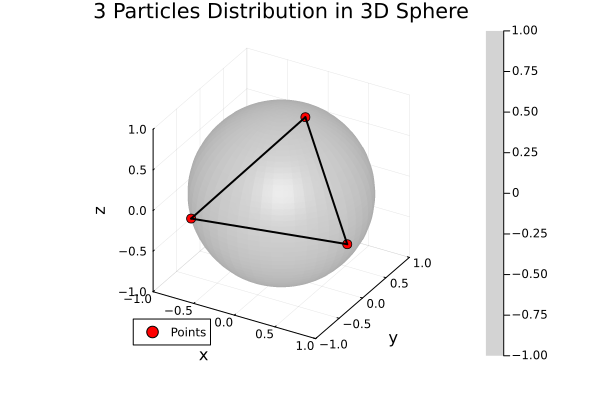

In [17]:
solveRandomThompson(3,3)

Converged in 19 iterations

Easier Energy: 2.2500000009069727
Grad: 2.250000001360433

X1: [-0.6959656612451331, 0.4435715908749356, 0.5646911032912624]
X2: [-0.245223717220055, -0.959461113490665, -0.13892336092980123]
X3: [0.05473766101038364, 0.46160641563159077, -0.8853944349920365]
X4: [0.8864517177055135, 0.054283107116775114, 0.4596266925002215]

True Energy: 3.674234614
Obtained Energy: 3.6742346147301737

Error with true value: 7.301736992815222e-10
Error Percentage: 1.987281096583568e-8%

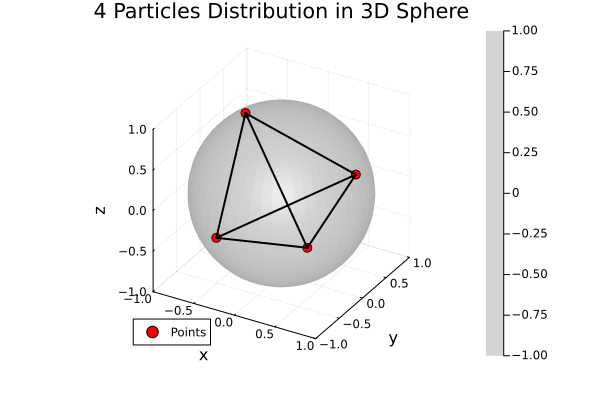

In [18]:
solveRandomThompson(3,4)

Converged in 46 iterations

Easier Energy: 4.25000002396472
Grad: 3.8024115395942486

X1: [-0.9945589350574778, -0.04225821122891273, 0.09521957929474448]
X2: [-0.05069948507156004, 0.9948875896822752, -0.08733983117496555]
X3: [-0.05341542405129572, -0.5766869265551021, -0.8152171374632959]
X4: [0.9945728381410185, 0.042408198789994966, -0.09500744343212193]
X5: [0.10409670591724098, -0.41839704070019806, 0.9022792207241038]

True Energy: 6.474691495
Obtained Energy: 6.474691508951859

Error with true value: 1.3951859223482188e-8
Error Percentage: 2.1548299612817597e-7%

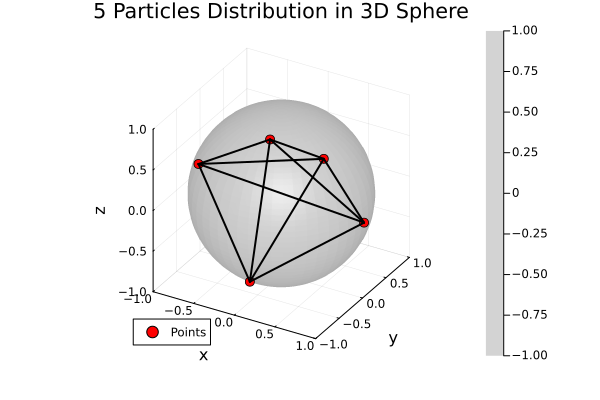

In [19]:
solveRandomThompson(3,5)

## Results (10 <= N < 50)


Easier Energy: 26.58479416162712
Grad: 18.250184715364806

True Energy: 32.71694946
Obtained Energy: 33.341398074648914

Error with true value: 0.6244486146489123
Error Percentage: 1.908639481845238%

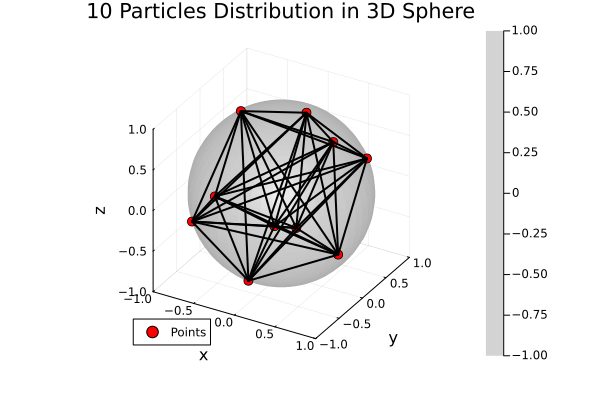

In [20]:
solveRandomThompson(3,10)


Easier Energy: 169.5969814779101
Grad: 124.8403436185036

True Energy: 150.881568334
Obtained Energy: 160.83208418377228

Error with true value: 9.950515849772273
Error Percentage: 6.594918093471329%

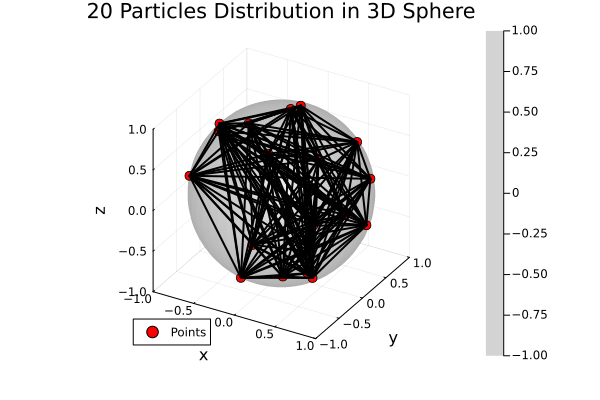

In [21]:
solveRandomThompson(3,20)


Easier Energy: 1081.5007942718348
Grad: 780.1542361544848

True Energy: 846.188401061
Obtained Energy: 880.2968394185407

Error with true value: 34.10843835754065
Error Percentage: 4.030832650834437%

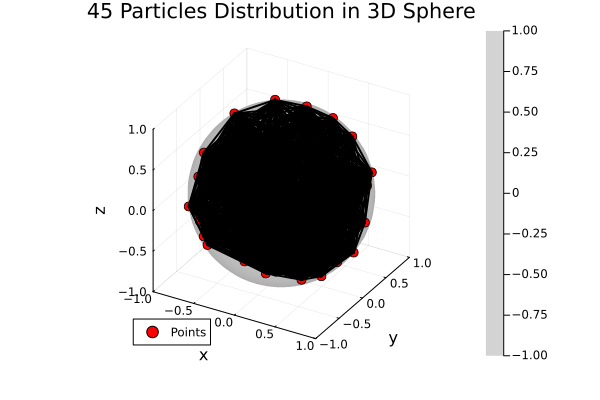

In [22]:
solveRandomThompson(3,45)

## Results (50 <= N <= 100)


Easier Energy: 1531.4354572052605
Grad: 575.4714981050261

True Energy: 1287.772720783
Obtained Energy: 1313.5716968489794

Error with true value: 25.798976065979332
Error Percentage: 2.003379606480006%

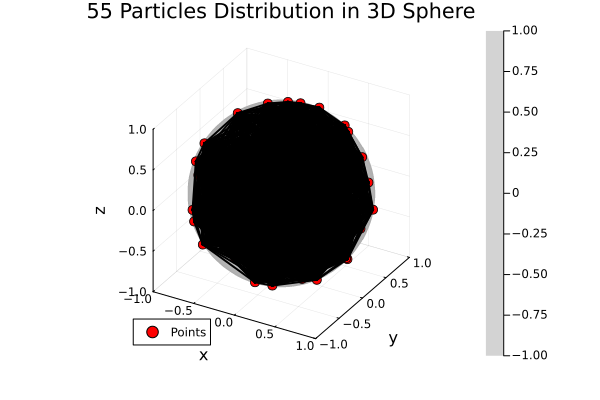

In [23]:
solveRandomThompson(3,55)


Easier Energy: 6066.545603589188
Grad: 5659.561748452012

True Energy: 4448.350634331
Obtained Energy: 4527.815796330367

Error with true value: 79.46516199936741
Error Percentage: 1.7863960944553194%

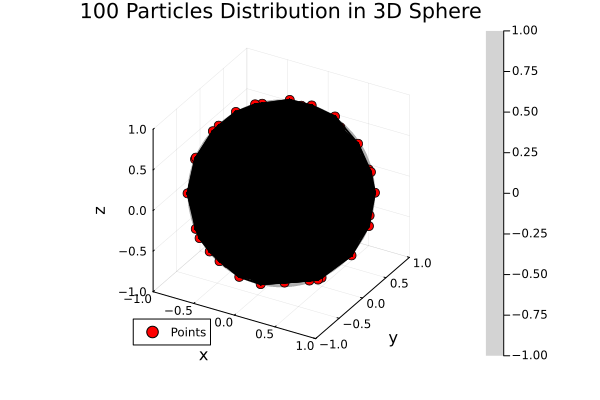

In [24]:
solveRandomThompson(3,100)

### Results K>3

In [25]:
solveRandomThompson(4,3)

Converged in 16 iterations

Easier Energy: 1.000000002244532
Grad: 1.1547005422668954

X1: [-0.6365509420405969, 0.3962526880328316, 0.3337292566985015, 0.5713243287638377]
X2: [0.019142930469247452, -0.9829099589584612, 0.01737173966420707, -0.18226295140363757]
X3: [0.6173499104812258, 0.5866511390071647, -0.3512297116270356, -0.3890465509432105]

In [26]:
solveRandomThompson(4,5)

Converged in 22 iterations

Easier Energy: 4.000000001990572
Grad: 3.577708766492191

X1: [0.6423231958700771, 0.7119571831394127, -0.26133050153593573, 0.11065374096893248]
X2: [0.3243245616725669, -0.44515326251836695, 0.19758687631526817, -0.8109325359566765]
X3: [-0.8452880525580025, 0.45545778968163275, 0.0014645653481299135, -0.279363857843784]
X4: [0.011350224684870326, -0.16527851860630102, 0.7863691776649786, 0.5951283055824304]
X5: [-0.13270992532783082, -0.5569831939122744, -0.7240901223096041, 0.38451435888978963]

In [27]:
solveRandomThompson(4,10)

Converged in 241 iterations

Easier Energy: 22.500000142524478
Grad: 14.230249562698567

In [28]:
solveRandomThompson(4,20)

Converged in 184 iterations

Easier Energy: 110.79926840524118
Grad: 49.550939268409024

In [29]:
solveRandomThompson(4,45)

Converged in 1229 iterations

Easier Energy: 664.544503863683
Grad: 198.1305292629363

In [30]:
solveRandomThompson(4,100)


Easier Energy: 4053.9265164873123
Grad: 3627.5622063054175